# We implement the German Traffic dataset on a convolutional network. Final Training Accuracy after 10 epochs: 1. 

# Final Validation Accuracy: 99.6% State of the art performance on the Test set is 99.8% using spatial transformer networks.

## High level description of network:

### CNN with 3 conv layers and 2 pooling layers feeding into a fully connected layer to a softmax output for predicting classes.
#### Optimizer: Adam with a learning rate schedule.
#### Regularization implemented simply using dropout of 0.5
#### Run 10 epochs on computer overnight. 

In [90]:
% matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Start by testing the network on mnist to make sure code works. 
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

In [ ]:
len(mnist.train.images)

In [445]:
# MNIST parameters
height = 28
width = 28
channels = 3
n_inputs = height*width

In [468]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape = [None, height, width, channels], name = "X")
#X_reshaped = tf.reshape(X, shape = [-1, height, width, channels], name = "X_reshaped")
y = tf.placeholder(tf.int32, shape = [None], name = "y")
training = tf.placeholder_with_default(False, shape = [], name = 'training')

In [469]:
# My Network parameters -- consider a simple network with alternating conv and pool layers
kern_conv_1 = 2
kern_conv_2 = 3
kern_conv_3 = 3

# Stride
conv_1_stride = 1
conv_2_stride = 1
conv_3_stride = 1

pool_1_stride = 2
pool_2_stride = 2

pool_1_padding = "VALID"
pool_2_padding = "VALID"

# of filter maps
filter_maps_1 = 30
filter_maps_2 = 60
filter_maps_3 = 120

fully_connected_maps = 300
fully_connected_maps_2 = 43

## Implement dropout regularization. 
dropout_rate = 0.5

#### Print number of parameters in the network. 

In [504]:
network_params = kern_conv_1**2*filter_maps_1 + kern_conv_2**2*filter_maps_2 + kern_conv_3**2*filter_maps_3 + (7*7*filter_maps_3)*fully_connected_maps
print("How many parameters in my network? Answer = ", network_params)
print("How many parameters in convolutional layers alone? Answer = ", kern_conv_1**2*filter_maps_1 + kern_conv_2**2*filter_maps_2 + kern_conv_3**2*filter_maps_3 )

How many parameters in my network? Answer =  1765740
How many parameters in convolutional layers alone? Answer =  1740


In [ ]:
# We don't use this module in final training. Instead we use tf.layers which has Xavier Initialization built in
def create_weights(size):
    return tf.Variable(tf.truncated_normal(size, stddev =0.05)) # 0.05 comes from Xavier Initialization for weights. 

def create_bias(size):
    return tf.Variable(tf.random_normal(stddev =0.05, shape = size))

weights = {
    #'w_0': create_weights([kern_conv0, kern_conv0, channels, filter_maps_0]),
    'w_1': create_weights([kern_conv_1, kern_conv_1, 1, filter_maps_1]),
    'w_2': create_weights([kern_conv_2, kern_conv_2, filter_maps_1, filter_maps_2]),
    'w_3': create_weights([kern_conv_3, kern_conv_3, filter_maps_2, filter_maps_3])
}

biases = {
    #'b_0': create_bias([filter_maps_0]),
    'b_1': create_bias([filter_maps_1]),
    'b_2': create_bias([filter_maps_2]),
    'b_3': create_bias([filter_maps_3])
}


In [473]:
# My network: AWESOME CONV NET.
# Image size after first pool layer = (28 - 2)/2 + 1 = [14 x 14 x 1] in conv_3 to 7 x 7 x 1 to the dense layer.
def awesome_conv_net_model(X):
    
    conv_1 = tf.layers.conv2d(X, filters=filter_maps_1, kernel_size=kern_conv_1,
                         strides=conv_1_stride, padding="SAME",
                         activation=tf.nn.relu, name="conv_1")
    
    
    conv_2 = tf.layers.conv2d(conv_1, filters=filter_maps_2, kernel_size=kern_conv_2,
                         strides=conv_2_stride, padding="SAME",
                         activation=tf.nn.relu, name="conv_2")
    
    pool_1 = tf.nn.max_pool(conv_2, ksize = [1, 2, 2, 1], strides = [1,pool_1_stride,pool_1_stride, 1], padding = pool_1_padding)
    
    conv_3 = tf.layers.conv2d(pool_1, filters=filter_maps_3, kernel_size=kern_conv_3,
                         strides=conv_3_stride, padding="SAME",
                         activation=tf.nn.relu, name="conv_3")
    pool_2 = tf.nn.max_pool(conv_3, ksize = [1, 2, 2, 1], strides = [1,pool_2_stride,pool_2_stride, 1], padding = pool_2_padding)
    
    pool_flat = tf.reshape(pool_2, [-1, 7*7*filter_maps_3])
    dense = tf.layers.dense(pool_flat, units = fully_connected_maps, activation = tf.nn.relu, name = "fc_dense")
    fc_drop = tf.layers.dropout(dense, dropout_rate, training=training)
    
    logits = tf.layers.dense(fc_drop, units = fully_connected_maps_2, activation = None)
    #print(np.shape(logits))
    
    return logits
    

In [470]:
initial_learning_rate = 0.001
decay_steps = 10000
decay_rate = 1/10

In [474]:
# Print weights for understanding. In hindsight, more useful to get Conv net weights than fully connected weights. 
with tf.name_scope("train"):
    logits = awesome_conv_net_model(X)
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    #regularizer = tf.nn.l2_loss(weights['w_1']) + tf.nn.l2_loss(weights['w_2a']) + tf.nn.l2_loss(weights['w_2b']) + tf.nn.l2_loss(weights['w_3a']) + tf.nn.l2_loss(weights['w_3b']) + tf.nn.l2_loss(weights['w_4'])                   
    loss = tf.reduce_mean(xentropy, name ="loss")
    global_step = tf.Variable(0, trainable= False)
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, decay_steps, decay_rate)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    training_op = optimizer.minimize(loss, global_step = global_step)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.variable_scope("fc_dense", reuse=True):
    w = tf.get_variable('kernel')

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()    

In [450]:
# Now we are ready to begin training this network
batch_size = 100
n_batches = len(mnist.train.images)//batch_size
epochs = 40

# we stop training after 6 epochs as it reaches pretty high accuracy quite quickly. 

In [ ]:
# Here we also implement early stopping

In [15]:
acc_epoch = np.zeros((epochs), dtype = float)
epoch_loss = np.zeros((epochs), dtype = float) # Validation set loss
train_epoch = np.zeros((epochs), dtype = float)
init = tf.global_variables_initializer()
best_loss_val = np.infty
check_counter = 0
max_checks = 20

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(epochs):
        print("epoch =", epoch)
        for iterator in range(n_batches):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
            loss_val = loss.eval(feed_dict={X: mnist.validation.images, y: mnist.validation.labels})
            #if iterator % 100 == 0:
            #    print("minibatch loss = ", loss_val)                
            #if loss_val < best_loss_val:
            #    best_loss_val =loss_val
            #    check_counter = 0
            #else:
            #    check_counter +=1
        acc_train = accuracy.eval(feed_dict= {X: X_batch, y: y_batch, training: True})
        acc_test = accuracy.eval(feed_dict={X: mnist.validation.images, y: mnist.validation.labels})
        
        #if check_counter > max_checks:
        #    print("Early Stopping!")
        #    break
        
        acc_epoch[epoch] = acc_test
        epoch_loss[epoch] = loss_val
        train_epoch[epoch] = acc_train
        print("Training Accuracy = ", acc_train, ", Test Accuracy = ", acc_test)
        print("Validation Loss = ", loss_val)
        
    save_path = saver.save(sess, "./my_mnist_model")
sess.close()

epoch = 0
Training Accuracy =  0.97 , Test Accuracy =  0.9828
Validation Loss =  0.0674768
epoch = 1
Training Accuracy =  0.97 , Test Accuracy =  0.9846
Validation Loss =  0.0542633
epoch = 2
Training Accuracy =  0.98 , Test Accuracy =  0.9844
Validation Loss =  0.0473951
epoch = 3
Training Accuracy =  0.99 , Test Accuracy =  0.987
Validation Loss =  0.0459755
epoch = 4
Training Accuracy =  1.0 , Test Accuracy =  0.9896
Validation Loss =  0.0425726
epoch = 5
Training Accuracy =  0.99 , Test Accuracy =  0.9868
Validation Loss =  0.0501942
epoch = 6


KeyboardInterrupt: 

# Pre Processing the traffic dataset. We follow the approach described in Geron's book for the flowers dataset.

In [97]:
import os
PATH = os.getcwd()
n_channels = 3

# Next we implement the inception on the German traffic signs dataset.

traffic_root_path = os.path.join(PATH, 'GTSRB/Final_Training/Images')

traffic_classes = sorted([dirname for dirname in os.listdir(traffic_root_path)
                         if os.path.isdir(os.path.join(traffic_root_path, dirname))])
#traffic_classes


In [108]:
my_orig_fig_path = os.path.join(PATH, "original_signs.png")

## Note that the signs are located in random parts of the image.
## So we use pandas to get the locations of the correct bounding boxes for the images from the csv files that come with the data. That's what bounding_box_paths is doing. 

In [121]:
from collections import defaultdict

image_paths = defaultdict(list)
bounding_box_paths = defaultdict(list)

for traffic_signs in traffic_classes:
    image_dir = os.path.join(traffic_root_path, traffic_signs)
    for filepath in os.listdir(image_dir):
        if filepath.endswith(".ppm"):
            image_paths[traffic_signs].append(os.path.join(image_dir, filepath))
            
# Next we import a collection of filepaths which contain the bounding box info.            
for traffic_signs in traffic_classes:
    image_dir = os.path.join(traffic_root_path, traffic_signs)
    for filepath in os.listdir(image_dir):
        if filepath.endswith(".csv"):
            bounding_box_paths[traffic_signs].append(os.path.join(image_dir, filepath))


### Make a directory containing the image paths and the image labels 

In [103]:
traffic_class_paths = []

for traffic in traffic_classes:
    for index, path in enumerate(image_paths[traffic]):
        image_dir = os.path.join(traffic_root_path, traffic)
        traffic_class_paths.append((os.path.join(image_dir, path), traffic))
            

In [214]:
np.shape(traffic_class_paths)

(39209, 2)

### Make a directory with the labels and the csv files to match the bounding box to the right image. 

In [122]:
bounding_box_paths

defaultdict(list,
            {'00000': ['/Users/stefan/Python_notebooks/GTSRB/Final_Training/Images/00000/GT-00000.csv'],
             '00001': ['/Users/stefan/Python_notebooks/GTSRB/Final_Training/Images/00001/GT-00001.csv'],
             '00002': ['/Users/stefan/Python_notebooks/GTSRB/Final_Training/Images/00002/GT-00002.csv'],
             '00003': ['/Users/stefan/Python_notebooks/GTSRB/Final_Training/Images/00003/GT-00003.csv'],
             '00004': ['/Users/stefan/Python_notebooks/GTSRB/Final_Training/Images/00004/GT-00004.csv'],
             '00005': ['/Users/stefan/Python_notebooks/GTSRB/Final_Training/Images/00005/GT-00005.csv'],
             '00006': ['/Users/stefan/Python_notebooks/GTSRB/Final_Training/Images/00006/GT-00006.csv'],
             '00007': ['/Users/stefan/Python_notebooks/GTSRB/Final_Training/Images/00007/GT-00007.csv'],
             '00008': ['/Users/stefan/Python_notebooks/GTSRB/Final_Training/Images/00008/GT-00008.csv'],
             '00009': ['/Users/stefan

### Look at a few original images. Notice that some are kind of dark. Higher accuracy could be achieved by brightening these images, which we leave as future work. For now, notice that the images are all different sizes and the actual sign is located in random parts of the image. 

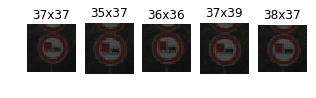

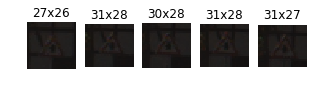

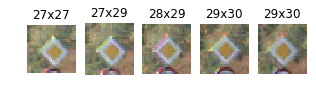

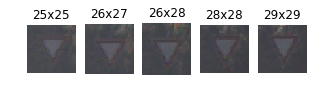

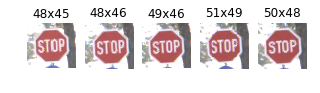

In [110]:
# Plot a few images

import matplotlib.image as mpimg

images_per_class = 5

for traffic_class in traffic_classes[10:15]:
    plt.figure(figsize = (5, 5))
    for index, filename in enumerate(image_paths[traffic_class][:images_per_class]):
        my_image = mpimg.imread(filename)[:, :, :n_channels]
        plt.subplot(100 + images_per_class * 10 + index + 1)
        plt.title("{}x{}".format(my_image.shape[1], my_image.shape[0]))
        plt.imshow(my_image)
        plt.axis("off")                                            
    plt.savefig(my_orig_fig_path)
    plt.show()

### Let's look inside one of the csv files containing bounding boxes. RoiX1...Roi.Y2 are the (x, y) positions of the bounding box containing the images. 

In [142]:
# Check out one file. Give it proper separator.

my_file = pd.read_csv("/Users/stefan/Python_notebooks/GTSRB/Final_Training/Images/00000/GT-00000.csv", sep = ';', encoding = "utf-8-sig")
my_file.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,00000_00000.ppm,29,30,5,6,24,25,0
1,00000_00001.ppm,30,30,5,5,25,25,0
2,00000_00002.ppm,30,30,5,5,25,25,0
3,00000_00003.ppm,31,31,5,5,26,26,0
4,00000_00004.ppm,30,32,5,6,25,26,0


In [143]:
my_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
Filename    210 non-null object
Width       210 non-null int64
Height      210 non-null int64
Roi.X1      210 non-null int64
Roi.Y1      210 non-null int64
Roi.X2      210 non-null int64
Roi.Y2      210 non-null int64
ClassId     210 non-null int64
dtypes: int64(7), object(1)
memory usage: 13.2+ KB


In [146]:
#my_file["Roi.X1"]

In [171]:
# Images are not centered and have random sizes -- we will use the bounding box list to first obtain the bounding 
# box containing the sign and then make all images 28*28*3. 

# from bounding box paths, we make an array of xmin, xmax, ymin, ymax ranges.
import pandas as pd

bound_box_array = []

for traffic in traffic_classes:
    for index, path in enumerate(bounding_box_paths[traffic]):
        myfile = pd.read_csv(path, sep = ";")
        bound_box_array.append([myfile["Roi.X1"], myfile["Roi.X2"], myfile["Roi.Y1"], myfile["Roi.Y2"]])    

In [200]:
bound_box_array[0]

[0       5
 1       5
 2       5
 3       5
 4       5
 5       6
 6       6
 7       6
 8       5
 9       6
 10      5
 11      6
 12      5
 13      6
 14      5
 15      6
 16      6
 17      6
 18      5
 19      5
 20      6
 21      6
 22      6
 23      7
 24      7
 25      7
 26      8
 27      9
 28     10
 29     12
        ..
 180     6
 181     6
 182     5
 183     5
 184     5
 185     6
 186     6
 187     6
 188     6
 189     5
 190     5
 191     6
 192     5
 193     6
 194     5
 195     6
 196     5
 197     5
 198     5
 199     5
 200     6
 201     6
 202     6
 203     6
 204     8
 205     8
 206     8
 207     9
 208     9
 209    10
 Name: Roi.X1, Length: 210, dtype: int64, 0       24
 1       25
 2       25
 3       26
 4       25
 5       26
 6       28
 7       29
 8       28
 9       30
 10      30
 11      32
 12      32
 13      35
 14      36
 15      39
 16      41
 17      42
 18      45
 19      48
 20      51
 21      53
 22      57
 23      64


### Write a simple function that takes an image and resizes it to center it around the correct bounding box. Further we homogenize all image sizes to 28x28

In [299]:
def center_image(image, traffic_label, index):
    x0 = bound_box_array[traffic_label][0][index]
    x1 = bound_box_array[traffic_label][1][index]
    y0 = bound_box_array[traffic_label][2][index]
    y1 = bound_box_array[traffic_label][3][index]
    
    return (imresize(image[x0:x1, y0:y1], (height, width)), traffic_label)

In [300]:
final_images = []
traffic_index = 0

for traffic in traffic_classes:
    for index, path in enumerate(image_paths[traffic], 0):
        input_image = mpimg.imread(path)
        final_images.append(center_image(input_image, traffic_index, index))
    traffic_index+=1        

### Plot a few images to see if this worked. Notice that the signs are properly centered now. 

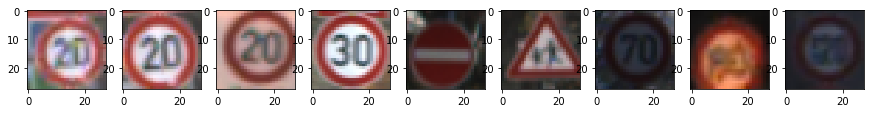

In [301]:
# Now we plot some final images.
cropped_input_path = os.path.join(PATH, "cropped_inputs.png")

plt.figure(figsize = (15, 8))
plt.subplot(191)
plt.imshow(final_images[1][0])
plt.subplot(192)
plt.imshow(final_images[10][0])
plt.subplot(193)
plt.imshow(final_images[100][0])
plt.subplot(194)
plt.imshow(final_images[1000][0])
plt.subplot(195)
plt.imshow(final_images[25000][0])
plt.subplot(196)
plt.imshow(final_images[31000][0])
plt.subplot(197)
plt.imshow(final_images[7000][0])
plt.subplot(198)
plt.imshow(final_images[8101][0])
plt.subplot(199)
plt.imshow(final_images[12000][0])
plt.savefig(cropped_input_path)
plt.show()

### Shuffle images to make training and test data. Normalize each separately to avoid contamination.

In [304]:
from random import shuffle
np.random.seed(42)
shuffle(final_images)

In [240]:
fake_list = [(1, 0), (2, 4), (4, 5), (6, 2)]
shuffle(fake_list)
fake_list

[(1, 0), (2, 4), (6, 2), (4, 5)]

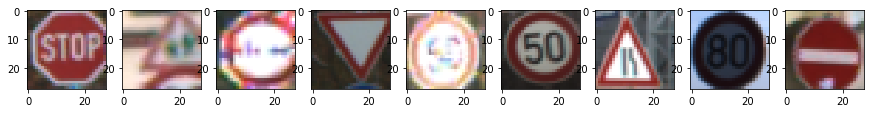

In [305]:
# Check that images are shuffled
plt.figure(figsize = (15, 8))
plt.subplot(191)
plt.imshow(final_images[1][0])
plt.subplot(192)
plt.imshow(final_images[10][0])
plt.subplot(193)
plt.imshow(final_images[100][0])
plt.subplot(194)
plt.imshow(final_images[1000][0])
plt.subplot(195)
plt.imshow(final_images[25000][0])
plt.subplot(196)
plt.imshow(final_images[31000][0])
plt.subplot(197)
plt.imshow(final_images[7000][0])
plt.subplot(198)
plt.imshow(final_images[8101][0])
plt.subplot(199)
plt.imshow(final_images[12000][0])
plt.show()

In [466]:
# Due to lack of a lot of data, we use more training data to get a better model and improve accuracy. 
train_val_split = 0.15
train_size = int(len(final_images)*(1-train_val_split))

train_set = final_images[:train_size]
val_set = final_images[train_size:]

print(len(train_set), len(val_set))

33327 5882


### Make Zero mean and unit stddeviation. 

In [426]:
X_val = [np.reshape(val_set[item][0], (height, width, n_channels))/np.float(255) for item in range(len(val_set))]
mean, std = np.mean(X_val), np.std(X_val)
X_val_final = (X_val - mean)/std
y_val = np.array([val_set[item][1] for item in range(len(val_set))], dtype = np.int32)

In [427]:
X_train = [np.reshape(train_set[item][0], (height, width, n_channels))/np.float(255) for item in range(len(train_set))]
y_train = np.array([train_set[item][1] for item in range(len(train_set))], dtype = np.int32)

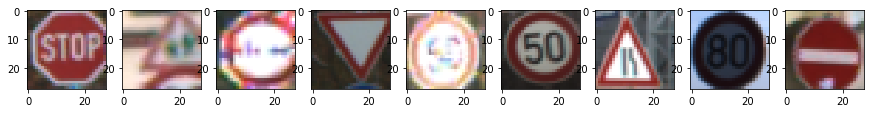

In [315]:
plt.figure(figsize = (15, 8))
plt.subplot(191)
plt.imshow(X_train[1])
plt.subplot(192)
plt.imshow(X_train[10])
plt.subplot(193)
plt.imshow(X_train[100])
plt.subplot(194)
plt.imshow(X_train[1000])
plt.subplot(195)
plt.imshow(X_train[25000])
plt.subplot(196)
plt.imshow(X_train[31000])
plt.subplot(197)
plt.imshow(X_train[7000])
plt.subplot(198)
plt.imshow(X_train[8101])
plt.subplot(199)
plt.imshow(X_train[12000])
plt.show()

In [465]:
batch_size = 100
n_batches = len(X_train)//batch_size
epochs = 10
print(n_batches)

372


### Get data in batches and zero mean and unit std.dev the data in each batch separately. 

In [464]:
import random

def fetch_batches(X, y, batch_size):
    X_batch = []
    iters = np.random.choice(np.arange(len(X)), size = batch_size) # randomly chooses batch_size elements from integers of size =training set
    X_batch = [X[iters] for iters in iters]
    batch_mean = np.mean(X_batch)
    batch_std = np.std(X_batch)
    y_batch = y[iters]
    #, 
    return (X_batch - batch_mean)/batch_std, y_batch.astype(np.int32)

### Plot training and validation sample data.

[40 33 12  4 11 20 26 37 38 11 12 23 25 34 11  4  3 11 10 20 10 16 34 13  4
 30  1  5  9  3  5 25 11  8  4 20 12 35  6  7 13 24 28 14 10 12  9 41 30  1
  8  7  8 12 33 13 38  9  2 25 38  6 10  3 23  2 13 12  6 30 13  3  6 13 10
 27 33  1 13 10 38 15 25 21 18  2 21 11  0  1 24 26 31 14 13  5 25  3 30  4]


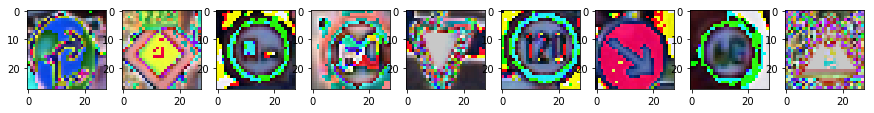

In [444]:
test_batch, test_data = fetch_batches(X_train, y_train, batch_size)
np.shape(test_batch)
print(test_data)
plt.figure(figsize = (15, 8))
plt.subplot(191)
plt.imshow(test_batch[1])
plt.subplot(192)
plt.imshow(test_batch[10])
plt.subplot(193)
plt.imshow(test_batch[20])
plt.subplot(194)
plt.imshow(test_batch[30])
plt.subplot(195)
plt.imshow(test_batch[40])
plt.subplot(196)
plt.imshow(test_batch[50])
plt.subplot(197)
plt.imshow(test_batch[60])
plt.subplot(198)
plt.imshow(test_batch[71])
plt.subplot(199)
plt.imshow(test_batch[91])
plt.show()

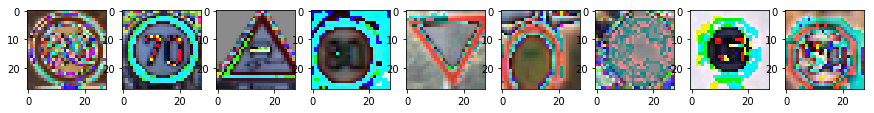

In [413]:
# Plot validation batch

plt.figure(figsize = (15, 8))
plt.subplot(191)
plt.imshow(X_val_final[1])
plt.subplot(192)
plt.imshow(X_val_final[10])
plt.subplot(193)
plt.imshow(X_val_final[20])
plt.subplot(194)
plt.imshow(X_val_final[30])
plt.subplot(195)
plt.imshow(X_val_final[40])
plt.subplot(196)
plt.imshow(X_val_final[50])
plt.subplot(197)
plt.imshow(X_val_final[60])
plt.subplot(198)
plt.imshow(X_val_final[71])
plt.subplot(199)
plt.imshow(X_val_final[91])
plt.show()

# Run the network on the traffic dataset.

In [475]:
acc_epoch = np.zeros((epochs), dtype = float)
epoch_loss = np.zeros((epochs), dtype = float) # Validation set loss
train_epoch = np.zeros((epochs), dtype = float)
weights_in_epoch = []
init = tf.global_variables_initializer()

#best_loss_val = np.infty
#check_counter = 0
#max_checks = 20

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(epochs):
        print("epoch =", epoch)
        for iterator in range(n_batches):
            X_batch, y_batch = fetch_batches(X_train, y_train, batch_size)
            _, weights = sess.run([training_op, w], feed_dict={X: X_batch, y: y_batch, training: True})
            loss_val = loss.eval(feed_dict={X: X_val_final, y: y_val})
            if iterator % 100 == 0:
                print("minibatch loss = ", loss_val)                
            #if loss_val < best_loss_val:
            #    best_loss_val =loss_val
            #    check_counter = 0
            #else:
            #    check_counter +=1
        acc_train = accuracy.eval(feed_dict= {X: X_batch, y: y_batch, training: True})
        acc_test = accuracy.eval(feed_dict={X: X_val_final, y: y_val})
        
        #if check_counter > max_checks:
        #    print("Early Stopping!")
        #    break
        
        acc_epoch[epoch] = acc_test
        epoch_loss[epoch] = loss_val
        train_epoch[epoch] = acc_train
        weights_in_epoch.append(weights)
        print("Training Accuracy = ", acc_train, ", Test Accuracy = ", acc_test)
        print("Validation Loss = ", loss_val)
        
    save_path = saver.save(sess, "./my_traffic_cnn")
sess.close()

epoch = 0
minibatch loss =  3.62458
minibatch loss =  0.990536
minibatch loss =  0.33384
minibatch loss =  0.180031
Training Accuracy =  0.93 , Test Accuracy =  0.961244
Validation Loss =  0.156249
epoch = 1
minibatch loss =  0.157493
minibatch loss =  0.107843
minibatch loss =  0.0775855
minibatch loss =  0.062757
Training Accuracy =  0.99 , Test Accuracy =  0.987761
Validation Loss =  0.0548458
epoch = 2
minibatch loss =  0.0554006
minibatch loss =  0.0463892
minibatch loss =  0.0439887
minibatch loss =  0.0388212
Training Accuracy =  0.99 , Test Accuracy =  0.990311
Validation Loss =  0.0377087
epoch = 3
minibatch loss =  0.0375547
minibatch loss =  0.0279047
minibatch loss =  0.0300707
minibatch loss =  0.0272627
Training Accuracy =  0.96 , Test Accuracy =  0.994901
Validation Loss =  0.0267293
epoch = 4
minibatch loss =  0.0269872
minibatch loss =  0.0253109
minibatch loss =  0.0291983
minibatch loss =  0.0254955
Training Accuracy =  0.98 , Test Accuracy =  0.994901
Validation Los

In [479]:
import os
PATH = os.getcwd()

## Plot training and validation accuracy. 

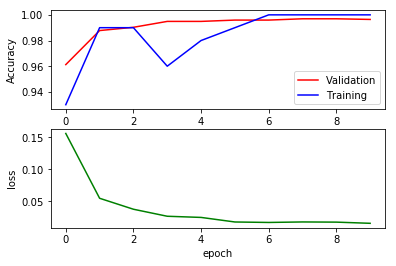

In [480]:
# So with our network we get over 99% accuracy on the validation set. Next we test this on the actual test set. 

fig_paths = os.path.join(PATH, "Traffic_CNN_test_val_accuracy.png")
plt.figure()
plt.subplot(211)
plt.plot(acc_epoch, 'r', label = 'Validation')
plt.plot(train_epoch, 'b', label = 'Training')
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.axis()
plt.legend()
plt.subplot(212)
plt.plot(epoch_loss, 'g', label = 'Loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig(fig_paths)
plt.show()


In [483]:
# Test the model on some images. 

with tf.Session() as sess:
    saver.restore(sess, "./my_traffic_cnn") # or better, use save_path
    X_new_scaled = X_val_final[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)

INFO:tensorflow:Restoring parameters from ./my_traffic_cnn


### Print actual and predicted classes to get mis labelled data. Note that label 40 is mislabeled.  

In [487]:
print("Predicted Classes = ", y_pred)
print("Actual Classes =    ", y_val[:20])

Predicted Classes =  [12 35 39 42  1 41 38 40  2 26 17 28 40 25  2  1  9 12 40 42]
Actual Classes =     [12 35 39 42  1 41 38 40  2 26 17 28 34 25  2  1  9 12 40 42]


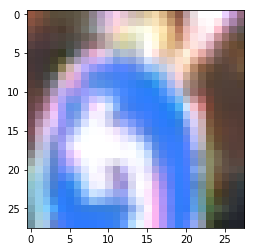

In [506]:
# Mis classified image. 
plt.imshow(X_val[12])

In [488]:
np.shape(weights_in_epoch)

(10, 5880, 300)

In [497]:
weights_in_epoch_reshaped = np.reshape(weights_in_epoch, (10, 5880*300))
arr_length = len(weights_in_epoch_reshaped[0])
np.max(weights_in_epoch_reshaped)

0.27654752

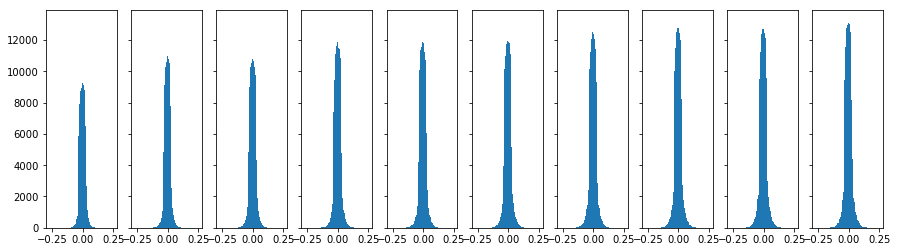

In [501]:
n_bins = 100
hist_path = os.path.join(PATH, "Traffic_weight_histogram_awesome_cnn.png")
fig, axs = plt.subplots(1, 10, sharex = True, sharey=True, tight_layout=False,figsize=(15, 4))
axs[0].hist(weights_in_epoch_reshaped[0][0:arr_length:10], bins = n_bins)
axs[1].hist(weights_in_epoch_reshaped[1][0:arr_length:10], bins = n_bins)
axs[2].hist(weights_in_epoch_reshaped[2][0:arr_length:10], bins = n_bins)
axs[3].hist(weights_in_epoch_reshaped[3][0:arr_length:10], bins = n_bins)
axs[4].hist(weights_in_epoch_reshaped[4][0:arr_length:10], bins = n_bins)
axs[5].hist(weights_in_epoch_reshaped[5][0:arr_length:10], bins = n_bins)
axs[6].hist(weights_in_epoch_reshaped[6][0:arr_length:10], bins = n_bins)
axs[7].hist(weights_in_epoch_reshaped[7][0:arr_length:10], bins = n_bins)
axs[8].hist(weights_in_epoch_reshaped[8][0:arr_length:10], bins = n_bins)
axs[9].hist(weights_in_epoch_reshaped[9][0:arr_length:10], bins = n_bins)
plt.savefig(hist_path)
plt.show()

#### The weights aren't telling me much except that they evolve to being closer to zero. 

## Summary: Pretty good performance on validation set for this simple but relevant dataset. 
#### Potential improvements: We can probably get better accuracy by increasing the dataset by simple augmentation -- affine transformations, rotations, etc. State of art performance was achieved using spatial transformer networks where a neural network is used to dictate the kind of augmentation to apply to the dataset. Implementing this is a project for future work. Another point to note is that some of the datasets are rather dark -- using a brightening to improve the contrast in the image will likely help improve accuracy. 


### Potential pitfalls to avoid:

#### 0) Data trained without using the bounding box performs poorly. Network spends time learning features that have nothing to do with the signs themselves. Using the provided bounding boxes greatly improves accuracy. 
#### 1) Make sure to zero mean and unit std dev the validation and batch data separately to avoid contamination. 
#### 2) Make sure the network sees the entire dataset. Earlier had a bug in the code because I was using tf.random.seed, which was generating the same permutation of the batches, and so the network was learning the same data over and over.
#### 3) Overall, the tf.layers method seems to work better than initializing weights ourselves, but need to explore this more. 
